## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from keras.datasets import cifar10
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
from keras.utils import np_utils
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization
from keras.layers import Dropout

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_L1L2_DROP(input_shape, output_units=10, num_neurons=[512, 256, 128], l1l2_ratio=1e-4, drp_ratio = 0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


def build_mlp_DROP(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



def build_mlp_BN(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
# Dropout_EXP = 0.25
MODEL = [build_mlp_L1L2_DROP, build_mlp_DROP, build_mlp_BN]
MOMENTUM = 0.95

In [12]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
import tensorflow as tf 
i = 0
for MOD in MODEL:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = MOD(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    if i == 0:
        name = 'L1L2_DROP'
    elif i == 1:
        name = 'DROP'
    else:
        name = 'BN'
    exp_name_tag = "Model-%s" % str(name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    i+=1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

C:\1_220107_Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 7s 34ms/step - loss: 18.9275 - accuracy: 0.1969 - val_loss: 17.4357 - val_accuracy: 0.3074
Epoch 2/50
196/196 [==============================] - 6s 32ms/step - loss: 16.2624 - accuracy: 0.2805 - val_loss: 15.0247 - val_accuracy: 0.3468
Epoch 3/50
196/196 [==============================] - 6s 32ms/step - loss: 14.0568 - accuracy: 0.3143 - val_loss: 13.0071 - val_accuracy: 0.3616
Epoch 4/50
196/196 [==============================] - 7s 33ms/step - loss: 12.1932 - accuracy: 0.3324 - val_loss: 11.2951 - val_accuracy: 0.3698
Epoch 5/50
196/196 [==============================] - 7s 33ms/step - loss: 10.6127 - accuracy: 0.3459 - val_loss: 9.8451 - val_accuracy: 0.3859
Epoch 6/50
196/196 [==============================] - 7s 33ms/step - loss: 9.2676 - accuracy: 0.3591 - val_loss: 8.6048 - val_accuracy: 0.3875
Epoch 7/50
196/196 [==============================] - 7s 34ms/step - loss: 8.1217 - accuracy: 0.3676 - val_loss: 7.5547 - val_accurac

 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 6s 27ms/step - loss: 2.1820 - accuracy: 0.1876 - val_loss: 1.9629 - val_accuracy: 0.3126
Epoch 2/50
196/196 [==============================] - 5s 25ms/step - loss: 1.9644 - accuracy: 0.2848 - val_loss: 1.8438 - val_accuracy: 0.3534
Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 1.8801 - accuracy: 0.3224 - val_loss: 1.7796 - val_accuracy: 0.3717
Epoch 4/50
196/196 [==============================] - 5s 26ms/step - loss: 1.8263 - accuracy: 0.3409 - val_loss: 1.7267 - val_accuracy: 0.3931
Epoch 5/50
196/196 [==

 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,

196/196 [==============================] - 6s 28ms/step - loss: 0.1613 - accuracy: 0.9573 - val_loss: 2.4890 - val_accuracy: 0.4736


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

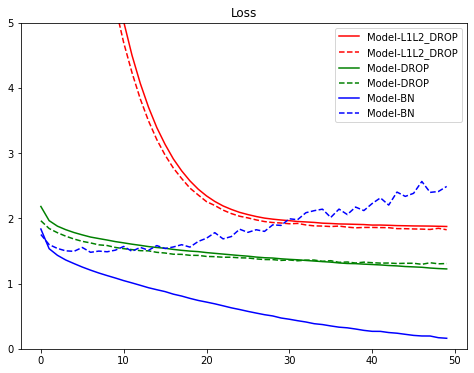

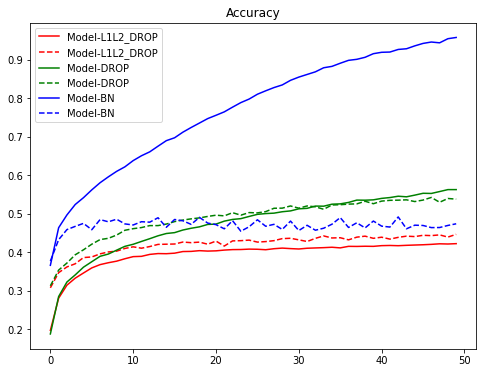

In [13]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
